In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [14]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

In [15]:
mnist_train = datasets.CIFAR10("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.CIFAR10("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
def standard_epoch(data_loader, model, loss_fn, optimizer = None):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #get the model prediction
        y_pred = model(X)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)
        

In [17]:
def train_standard_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print(*(i.format(i) for i in ("Train Loss", "Test Loss", "Train Error", "Test Error")), sep="\t")
    for epoch in range(num_epochs):
        # model.train()
        train_loss, train_accuracy = standard_epoch(train_loader, model, loss_fn, optimizer)
        # model.eval()
        test_loss, test_accuracy = standard_epoch(test_loader, model, loss_fn)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(*("{:.6f}".format(i) for i in (train_loss, test_loss, train_accuracy, test_accuracy)), sep="\t")
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [27]:
#Define 4 different models for evaluation

model_shallow_dnn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
shallow_dnn_optimizer = optim.Adam(model_shallow_dnn.parameters(), lr=0.001)

model_deep_dnn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
deep_dnn_optimizer = optim.Adam(model_deep_dnn.parameters(), lr=0.001)

model_standard_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(1600, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
standard_cnn_optimizer = optim.Adam(model_standard_cnn.parameters(), lr=0.001)

#include some dropout layers and batch normalization
model_complex_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.5),
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.5),
    nn.Flatten(),
    nn.Linear(1600, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
complex_cnn_optimizer = optim.Adam(model_complex_cnn.parameters(), lr=0.001)

models = [
    (model_shallow_dnn, shallow_dnn_optimizer, "Shallow DNN"),
    (model_deep_dnn, deep_dnn_optimizer, "Deep DNN"),
    (model_standard_cnn, standard_cnn_optimizer, "Standard CNN"),
    (model_complex_cnn, complex_cnn_optimizer, "Complex CNN")
]

In [28]:
def plot_model_training(train_losses, test_losses, train_accuracies, test_accuracies, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    plt.suptitle(title)

    axs[0].plot(train_losses, label="Train")
    axs[0].plot(test_losses, label="Test")
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(train_accuracies, label="Train")
    axs[1].plot(test_accuracies, label="Test")
    axs[1].set_title("Accuracy")
    axs[1].legend()

    plt.show()

Train Loss	Test Loss	Train Error	Test Error
1.899887	1.775355	0.319740	0.368300
1.735726	1.687816	0.383520	0.400600
1.662053	1.627178	0.410740	0.416600
1.620294	1.596239	0.425080	0.432800
1.591057	1.608060	0.433520	0.427600
1.567426	1.560556	0.443240	0.443600
1.548534	1.596523	0.450020	0.423400
1.538885	1.549524	0.453120	0.452300
1.520173	1.556115	0.460520	0.451700
1.510975	1.532967	0.464180	0.454000


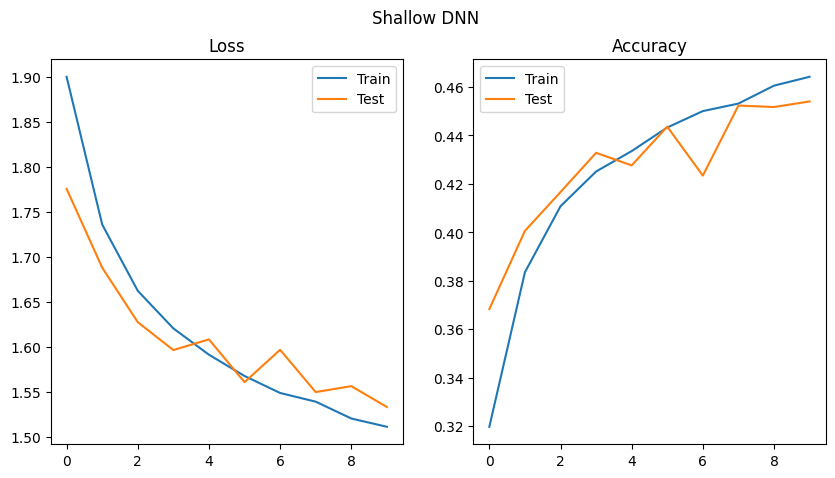

Train Loss	Test Loss	Train Error	Test Error
1.878532	1.705652	0.313180	0.377000
1.687346	1.620243	0.392520	0.418900
1.598664	1.573005	0.427220	0.430600
1.532010	1.494698	0.452220	0.466500
1.480445	1.474450	0.470740	0.474300
1.448151	1.462063	0.482200	0.477800
1.412711	1.483329	0.495980	0.484200
1.381695	1.429854	0.505860	0.488500
1.357414	1.432918	0.514580	0.489800
1.326585	1.412578	0.523900	0.493000


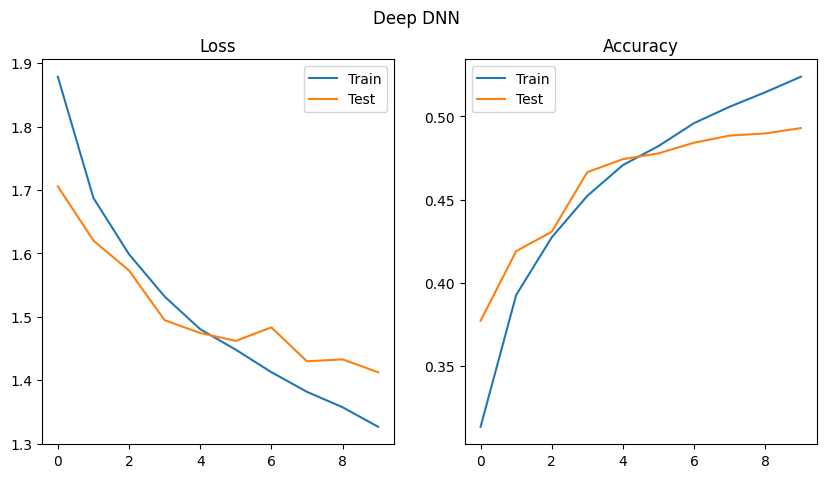

Train Loss	Test Loss	Train Error	Test Error
1.584405	1.368820	0.421660	0.514300
1.260881	1.177443	0.548340	0.581700
1.123399	1.103272	0.603620	0.614400
1.034796	1.065468	0.633940	0.627500
0.953907	0.968117	0.665180	0.661300
0.887121	0.954821	0.689500	0.669800
0.843994	0.932135	0.704000	0.676300
0.794408	0.908143	0.721500	0.688100
0.746263	0.895030	0.738800	0.691000
0.703994	0.914481	0.753480	0.688500


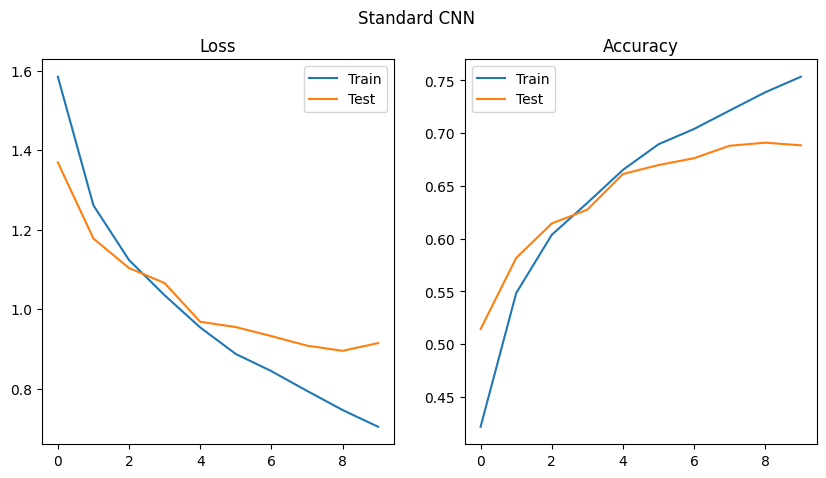

Train Loss	Test Loss	Train Error	Test Error
1.613309	1.449978	0.418800	0.479400
1.392198	1.379677	0.502500	0.505300
1.306940	1.325374	0.536780	0.531900
1.249278	1.266990	0.559920	0.550600
1.194024	1.215863	0.579600	0.575900
1.154119	1.227325	0.593280	0.572100
1.126586	1.210358	0.604460	0.581500
1.098350	1.182143	0.613600	0.588400
1.069991	1.173678	0.624560	0.596000
1.056214	1.162772	0.631540	0.596900


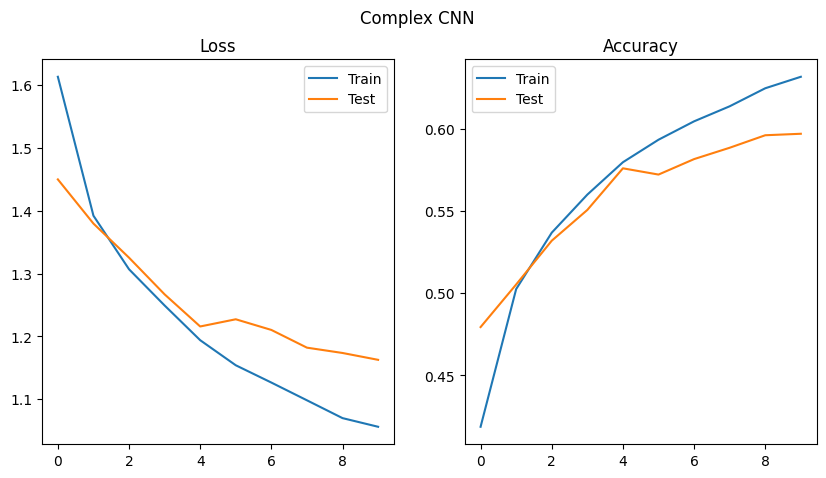

In [29]:
#train the models
for model, optimizer, name in models:
    train_losses, test_losses, train_accuracies, test_accuracies = train_standard_model(model, train_loader, test_loader, nn.CrossEntropyLoss(), optimizer, 10)
    #plot the training curves
    
    plot_model_training(train_losses, test_losses, train_accuracies, test_accuracies, name)
    

In [30]:
#define attacks methods
def fgsm(model, X, y, loss_fn, epsilon=0.1):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = loss_fn(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, loss_fn, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def norms(Z):
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, loss_fn, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = loss_fn(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()
        
    return delta.detach()

In [31]:
def adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, optimizer=None, **kwargs):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #generate adversarial perturbation
        delta = attack_fn(model, X, y, loss_fn, epsilon, **kwargs)
        X_adv = X + delta
        
        #get the model prediction on the adversarial example
        y_pred = model(X_adv)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)

In [32]:
def evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs):
    model.eval()
    test_loss, test_accuracy = adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, **kwargs)
    
    return test_loss, test_accuracy

In [33]:
def evaluate_model_accuracy_for_epsilons(model, data_loader, loss_fn, attack_fn, epsilon_values, **kwargs):
    accuracies = []
    
    for epsilon in epsilon_values:
        _, accuracy = evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs)
        accuracies.append(accuracy)
        
    return accuracies

In [34]:
attack_methods = [
    (fgsm, "FGSM", {}),
    (pgd_linf, "PGD", {"alpha": 0.01, "num_iter": 40}),
    (pgd_l2, "PGD L2", {"alpha": 0.01, "num_iter": 40})
]

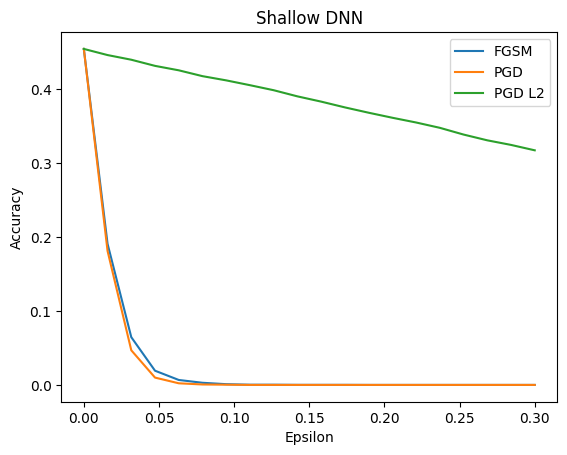

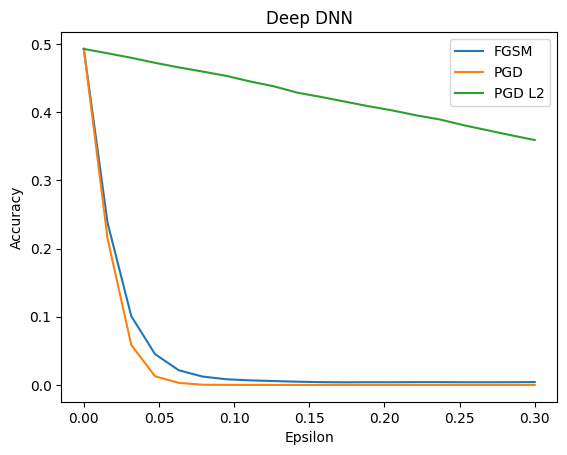

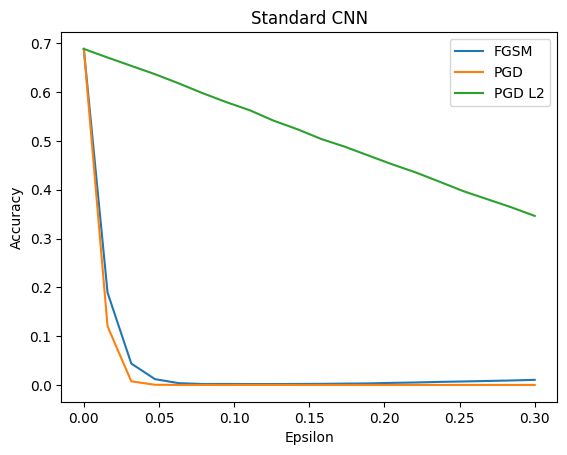

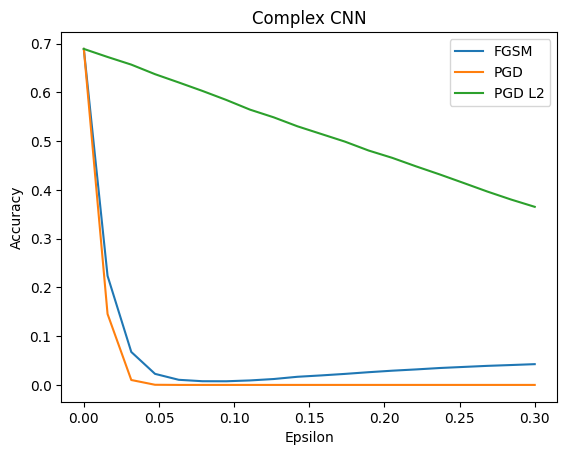

In [35]:
#plot model accuracy versus epsilon for all the attack methods
for model, _, name in models:
    for attack_fn, attack_name, attack_kwargs in attack_methods:
        accuracies = evaluate_model_accuracy_for_epsilons(model, test_loader, nn.CrossEntropyLoss(), attack_fn, np.linspace(0, 0.3, 20), **attack_kwargs)
        plt.plot(np.linspace(0, 0.3, 20), accuracies, label=attack_name)
        
    plt.title(name)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Now we will plot what some of these adversarial examples look like

In [36]:
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    break

In [63]:
def plot_images(X,y,yp,M,N, title):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    plt.suptitle(title)
    for i in range(M):
        for j in range(N):
            #switch to numpy data format and reorder dimensions from CWH to WHC
            ax[i][j].imshow(X[i*N+j].cpu().numpy().transpose(1,2,0).clip(0,1))
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

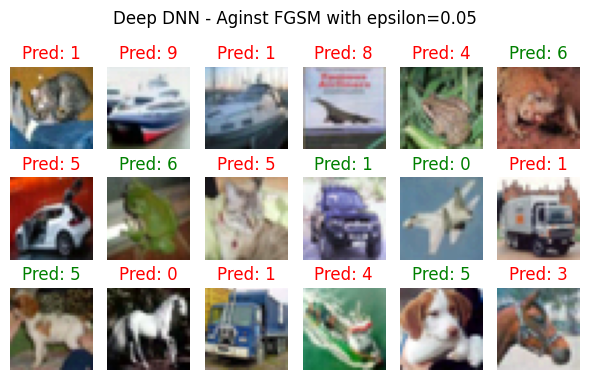

In [64]:
delta_dnn_2 = fgsm(model_deep_dnn, imgs ,labels, nn.CrossEntropyLoss(), 0.01)
yp = model_deep_dnn(imgs + delta_dnn_2)
plot_images(imgs+delta_dnn_2, labels, yp, 3, 6, "Deep DNN - Aginst FGSM with epsilon=0.05")

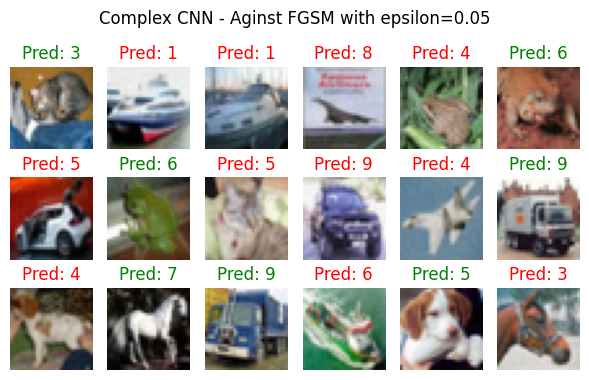

In [65]:
delta_complex_cnn = fgsm(model_complex_cnn, imgs ,labels, nn.CrossEntropyLoss(), 0.01)
yp = model_complex_cnn(imgs + delta_complex_cnn)
plot_images(imgs+delta_complex_cnn, labels, yp, 3, 6, "Complex CNN - Aginst FGSM with epsilon=0.05")

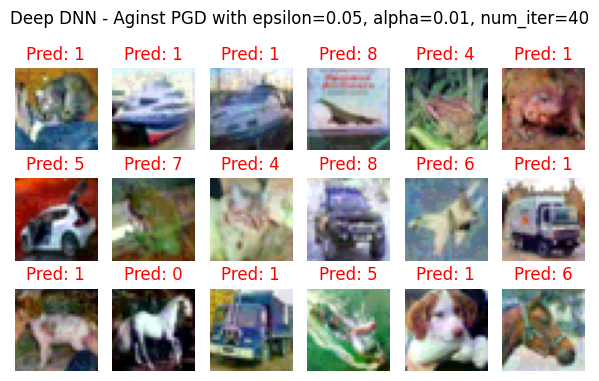

In [66]:
delta_dnn_2 = pgd_linf(model_deep_dnn, imgs ,labels, nn.CrossEntropyLoss(), 0.05, alpha=0.01, num_iter=40)
yp = model_deep_dnn(imgs + delta_dnn_2)
plot_images(imgs+delta_dnn_2, labels, yp, 3, 6, "Deep DNN - Aginst PGD with epsilon=0.05, alpha=0.01, num_iter=40")

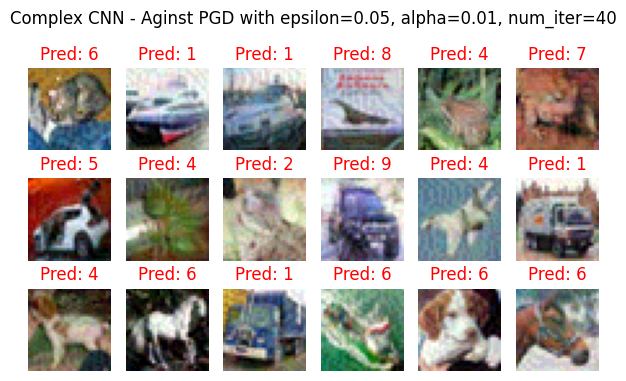

In [67]:
delta_complex_cnn = pgd_linf(model_complex_cnn, imgs ,labels, nn.CrossEntropyLoss(), 0.05, alpha=0.01, num_iter=40)
yp = model_complex_cnn(imgs + delta_complex_cnn)
plot_images(imgs+delta_complex_cnn, labels, yp, 3, 6, "Complex CNN - Aginst PGD with epsilon=0.05, alpha=0.01, num_iter=40")

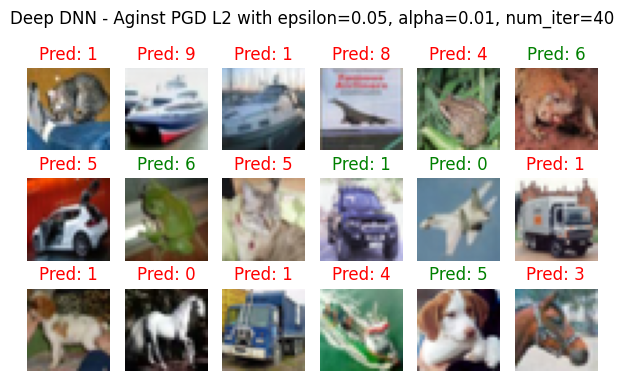

In [68]:
delta_dnn_2 = pgd_l2(model_deep_dnn, imgs ,labels, nn.CrossEntropyLoss(), 1, alpha=0.01, num_iter=40)
yp = model_deep_dnn(imgs + delta_dnn_2)
plot_images(imgs+delta_dnn_2, labels, yp, 3, 6, "Deep DNN - Aginst PGD L2 with epsilon=0.05, alpha=0.01, num_iter=40")

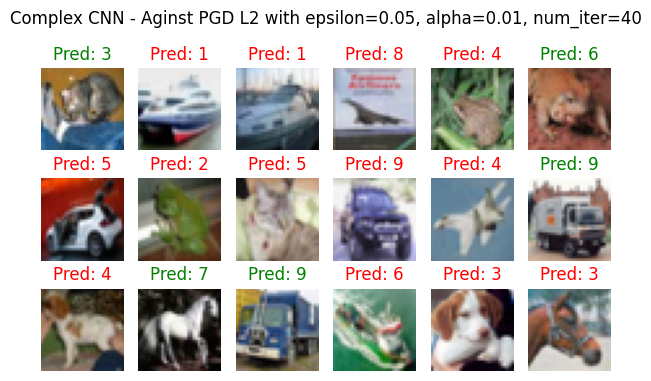

In [70]:
delta_complex_cnn = pgd_l2(model_complex_cnn, imgs ,labels, nn.CrossEntropyLoss(), 1, alpha=0.01, num_iter=40)
yp = model_complex_cnn(imgs + delta_complex_cnn)
plot_images(imgs+delta_complex_cnn, labels, yp, 3, 6, "Complex CNN - Aginst PGD L2 with epsilon=0.05, alpha=0.01, num_iter=40")

In [46]:
#save the models to disk
torch.save(model_shallow_dnn.state_dict(), "models/regular_model_shallow_dnn_CIFAR.pth")
torch.save(model_deep_dnn.state_dict(), "models/regular_model_deep_dnn_CIFAR.pth")
torch.save(model_standard_cnn.state_dict(), "models/regular_model_standard_cnn_CIFAR.pth")
torch.save(model_complex_cnn.state_dict(), "models/regular_model_complex_cnn_CIFAR.pth")